### The goal of this project is to complete the Aspect-based Sentiment Analysis (ABSA) task. ABSA task aims at identifying the sentiment polarity (e.g.positive, negative, neutral) of one specific aspect in its context sentence usig Deep Learning Models, Natural language Processing and Attention Mechanism. 

### We  design different model variants to differently integrate the aspect information in our model structures (e.g. different locations, different integration methods etc. ) using Attention Mechanism. 

# 1.Dataset Processing

**Note:**

*   Change path to dataset location.


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Loading Train set
train_df = pd.read_json('/content/drive/MyDrive/Colab Notebooks/NLP/Assignment/train.json', lines=True)
train_data = train_df['data'][0]
Sentence, Aspect, Polarity = zip(*train_data)
train_data = pd.DataFrame()
train_data["Sentences"]= Sentence
train_data["Aspect"]= Aspect
train_data["Polarity"]= Polarity
corpus_np = train_data.to_numpy() # Creating a numpy array for train_data

In [ ]:
#Loading Test set
test_df = pd.read_json('/content/drive/MyDrive/Colab Notebooks/NLP/Assignment/test.json', lines=True)
test_data = test_df['data'][0]
Sentence, Aspect, Polarity = zip(*test_data)
test_data = pd.DataFrame()
test_data["Sentences"]= Sentence
test_data["Aspect"]= Aspect
test_data["Polarity"]= Polarity
test_corpus_np = test_data.to_numpy() # Creating a numpy array for test_data

In [ ]:
#Loading Validation set
val_df = pd.read_json('/content/drive/MyDrive/Colab Notebooks/NLP/Assignment/val.json', lines=True)
val_data = val_df['data'][0]
Sentence, Aspect, Polarity = zip(*val_data)
val_data = pd.DataFrame()
val_data["Sentences"]= Sentence
val_data["Aspect"]= Aspect
val_data["Polarity"]= Polarity
val_corpus_np = val_data.to_numpy()# Creating a numpy array for val_data

In [ ]:
train_data.head()

,Sentences,Aspect,Polarity
0,It might be the best sit down food I've had in...,food,positive
1,It might be the best sit down food I've had in...,place,neutral
2,Hostess was extremely accommodating when we ar...,staff,positive
3,Hostess was extremely accommodating when we ar...,miscellaneous,neutral
4,We were a couple of minutes late for our reser...,miscellaneous,neutral


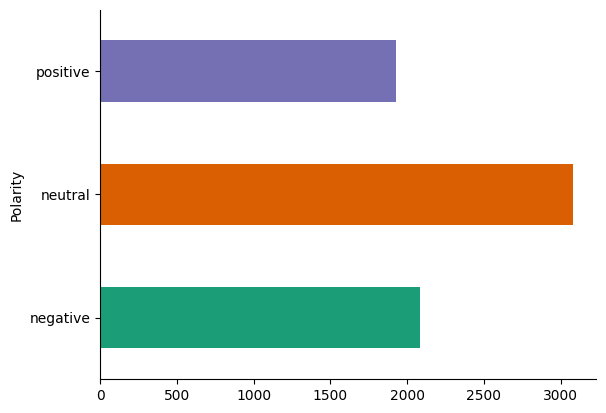

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
train_data.groupby('Polarity').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

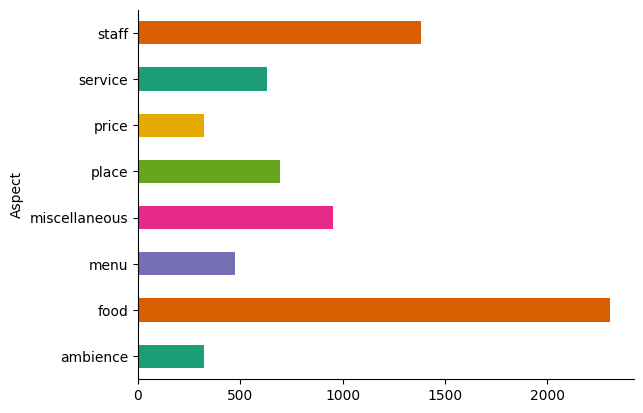

In [ ]:
train_data.groupby('Aspect').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

### Data Preparation

In [ ]:
!pip install nltk
!python -m nltk.downloader punkt
!python -m nltk.downloader stopwords
!python -m nltk.downloader wordnet

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package wordnet to /root/nltk_data.

In [ ]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
def preprocess(data):
  sww = stopwords.words()
  lemmatizer = WordNetLemmatizer()
  for i in range(len(data)):
    data[i][0] = re.sub(r'[^\w\s]',' ',data[i][0]) # remove punctuations and replacing with space
    data[i][0] = word_tokenize(data[i][0]) # Word Tokenization
    data[i][0] = [t.lower() for t in data[i][0]] # changing to lowercase
    data[i][0] = [w for w in data[i][0] if not w in sww] # remove stopwords
    data[i][0] = [lemmatizer.lemmatize(w) for w in data[i][0]] # Lemmatization
  return data

In [ ]:
def preprocess_sww(data):
  #sww = stopwords.words()
  lemmatizer = WordNetLemmatizer()
  for i in range(len(data)):
    data[i][0] = re.sub(r'[^\w\s]',' ',data[i][0]) # remove punctuations and replacing with space
    data[i][0] = word_tokenize(data[i][0]) # Word Tokenization
    data[i][0] = [t.lower() for t in data[i][0]] # changing to lowercase
    #data[i][0] = [w for w in data[i][0] if not w in sww] # remove stopwords
    data[i][0] = [lemmatizer.lemmatize(w) for w in data[i][0]] # Lemmatization
  return data

In [ ]:
def preprocess_c_sww(data):
    # If custom_stopwords is not provided, use the default stopwords
    sww=stopwords.words()
    custom_stopwords = ['not', 'no', 'never', 'should','shouldnt', 'would', 'wouldnt', 'wont', 'isnt', 'hadnt', 'again', 'bc',
                    'hasnt', 'havent', 'wasnt', 'werent']

    lemmatizer = WordNetLemmatizer()

    # Preprocess each data point
    for i in range(len(data)):
        # Remove punctuations and replace them with space
        data[i][0] = re.sub(r'[^\w\s]', ' ', data[i][0])
        # Tokenize the sentence
        data[i][0] = word_tokenize(data[i][0])
        # Convert words to lowercase
        data[i][0] = [t.lower() for t in data[i][0]]
        # Remove stopwords except for custom stopwords
        data[i][0] = [w for w in data[i][0] if w in custom_stopwords or w not in stopwords.words()]
        # Lemmatization
        data[i][0] = [lemmatizer.lemmatize(w) for w in data[i][0]]

    return data


In [ ]:
corpus_np_cp=np.copy(corpus_np)
test_corpus_np_cp=np.copy(test_corpus_np)
val_corpus_np_cp=np.copy(val_corpus_np)

train_corpus = preprocess(corpus_np_cp) # Preprocessing train corpus
test_corpus = preprocess(test_corpus_np_cp) # Preprocessing test corpus
val_corpus = preprocess(val_corpus_np_cp) # Preprocessing validation corpus

In [ ]:
corpus_np_cp_1=np.copy(corpus_np)
test_corpus_np_1=np.copy(test_corpus_np)
val_corpus_np_1=np.copy(val_corpus_np)

train_corpus_sww = preprocess_sww(corpus_np_cp_1) # Preprocessing train corpus without removing Stopwords
test_corpus_sww = preprocess_sww(test_corpus_np_1) # Preprocessing test corpus without removing Stopwords
val_corpus_sww = preprocess_sww(val_corpus_np_1) # Preprocessing validation corpus without removing Stopwords

In [ ]:
train_corpus_c_sww = preprocess_c_sww(corpus_np) # Preprocessing train corpus removing custom Stopwords
test_corpus_c_sww = preprocess_c_sww(test_corpus_np) # Preprocessing test corpus removing custom Stopwords
val_corpus_c_sww = preprocess_c_sww(val_corpus_np) # Preprocessing validation corpus removing custom Stopwords

In [65]:
max_length, position = max((len(r[0]), i) for i, r in enumerate(train_corpus_c_sww))

print("Maximum Length:", max_length)
print("Position:", position)

Maximum Length: 41
Position: 4042


### Using Glove-wiki-50

In [ ]:
import gensim.downloader as api

word_vectors = api.load("glove-wiki-gigaword-50") # Using pre-trained word embedding

# 2. Model Implementation


## Bi-LSTM Varient-1

### Batch Creation Varient-1

In [ ]:
def model_1_batches(data, batch_size, max_len):
    batches = []
    polarity_map = {'positive': 0, 'neutral': 1, 'negative': 2}

    for i in range(0, len(data), batch_size):
        batch = []

        for j in range(i, min(i + batch_size, len(data))):
            sentence = data[j][0]
            aspect = data[j][1]
            polarity = data[j][2]
            embedding_list = []
            for word in sentence: # Check if word exist in pre-trained word embedding else appending zero vector
                if str(word) in word_vectors:
                    embedding_list.append(word_vectors[word])
                else:
                    embedding_list.append(np.zeros(50))

            embedding_list.append(word_vectors[aspect])

            for _ in range(max_len - len(embedding_list)):
                embedding_list.append(np.zeros(50))

            sentence_vectors = torch.tensor(embedding_list, dtype=torch.float32)
            polarity = torch.tensor(polarity_map[polarity], dtype=torch.long)

            batch.append((sentence_vectors, polarity))

        batches.append(batch)

    return batches

### Bi-LSTM Model

Input format for the model: "Sentence" + "Aspect" + "Padding"

In [328]:
# Define the BiLSTM model
class BiLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiLSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,batch_first =True, bidirectional=True)
        self.fc = nn.Linear(2*hidden_size,num_classes)


    def forward(self, x):

        x,(h_n,c_n) = self.lstm(x)

        hidden_out = torch.cat((h_n[2,:,:],h_n[3,:,:]),1)
        output = self.fc(hidden_out)
        return(output)

### Training: without stopwords

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
input_size = 50
hidden_size = 128
num_layers = 2
num_classes = 3
batch_size = 256
num_epochs = 20
learning_rate = 0.001

# Batch Creation
max_len = 50
batches = model_1_batches(train_corpus, batch_size, max_len)

model_1 = BiLSTMClassifier(input_size, hidden_size, num_layers=2, num_classes=3).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    train_loss = 0
    for batch in batches:
        sentence_vectors, polarities = zip(*batch)
        sentence_vectors = torch.stack(sentence_vectors).to(device)
        polarities = torch.stack(polarities).to(device)
        model_1.train()
        optimizer.zero_grad()
        outputs = model_1(sentence_vectors)
        loss = criterion(outputs, polarities)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}')

model_1.eval()
with torch.no_grad():
  correct=0
  total=0
  for batch in batches:
    sentence_vectors, polarities = zip(*batch)
    sentence_vectors = torch.stack(sentence_vectors).to(device)
    polarities = torch.stack(polarities).to(device)

    outputs = model_1(sentence_vectors)
    _, predicted = torch.max(outputs.data, 1)
    total += polarities.size(0)
    correct += (predicted == polarities).sum().item()
  accuracy = 100 * correct / total
  print(f'Train Accuracy: {accuracy:.2f}%')

<ipython-input-18-8fe9946e8c6e>:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  sentence_vectors = torch.tensor(embedding_list, dtype=torch.float32)


Epoch [1/20], Loss: 29.5661
Epoch [2/20], Loss: 26.9541
Epoch [3/20], Loss: 24.6914
Epoch [4/20], Loss: 23.9469
Epoch [5/20], Loss: 23.3950
Epoch [6/20], Loss: 22.8834
Epoch [7/20], Loss: 22.4746
Epoch [8/20], Loss: 22.0010
Epoch [9/20], Loss: 21.6393
Epoch [10/20], Loss: 21.2729
Epoch [11/20], Loss: 20.9831
Epoch [12/20], Loss: 20.5057
Epoch [13/20], Loss: 20.1460
Epoch [14/20], Loss: 19.3784
Epoch [15/20], Loss: 18.5797
Epoch [16/20], Loss: 18.0732
Epoch [17/20], Loss: 17.6600
Epoch [18/20], Loss: 17.6032
Epoch [19/20], Loss: 17.2177
Epoch [20/20], Loss: 17.3905
Train Accuracy: 74.10%


Accuracy Checking

In [ ]:
model_1.eval()
with torch.no_grad():
  correct=0
  total=0
  batches = model_1_batches(test_corpus, batch_size, max_len)
  for batch in batches:
    sentence_vectors, polarities = zip(*batch)
    sentence_vectors = torch.stack(sentence_vectors).to(device)
    polarities = torch.stack(polarities).to(device)

    outputs = model_1(sentence_vectors)
    _, predicted = torch.max(outputs.data, 1)
    total += polarities.size(0)
    correct += (predicted == polarities).sum().item()
  accuracy = 100 * correct / total
  print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 61.15%


### Training: with stopwords

In [329]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
input_size = 50
hidden_size = 128
num_layers = 2
num_classes = 3
batch_size = 256
num_epochs = 20
learning_rate = 0.001

# Batch Creation
max_len = 70
batches = model_1_batches(train_corpus_sww, batch_size, max_len)

model_1_sww = BiLSTMClassifier(input_size, hidden_size, num_layers=2, num_classes=3).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1_sww.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    train_loss = 0
    for batch in batches:
        sentence_vectors, polarities = zip(*batch)
        sentence_vectors = torch.stack(sentence_vectors).to(device)
        polarities = torch.stack(polarities).to(device)
        model_1_sww.train()
        optimizer.zero_grad()

        outputs = model_1_sww(sentence_vectors)
        loss = criterion(outputs, polarities)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}')

model_1_sww.eval()
with torch.no_grad():
  correct=0
  total=0
  for batch in batches:
    sentence_vectors, polarities = zip(*batch)
    sentence_vectors = torch.stack(sentence_vectors).to(device)
    polarities = torch.stack(polarities).to(device)

    outputs = model_1_sww(sentence_vectors)
    _, predicted = torch.max(outputs.data, 1)
    total += polarities.size(0)
    correct += (predicted == polarities).sum().item()
  accuracy = 100 * correct / total
  print(f'Train Accuracy: {accuracy:.2f}%')

Epoch [1/20], Loss: 29.7575
Epoch [2/20], Loss: 28.8167
Epoch [3/20], Loss: 27.6265
Epoch [4/20], Loss: 25.6615
Epoch [5/20], Loss: 24.8092
Epoch [6/20], Loss: 25.6300
Epoch [7/20], Loss: 24.4182
Epoch [8/20], Loss: 24.0011
Epoch [9/20], Loss: 23.6244
Epoch [10/20], Loss: 23.5575
Epoch [11/20], Loss: 23.4395
Epoch [12/20], Loss: 23.0348
Epoch [13/20], Loss: 22.7402
Epoch [14/20], Loss: 22.4790
Epoch [15/20], Loss: 22.3577
Epoch [16/20], Loss: 22.2226
Epoch [17/20], Loss: 21.7619
Epoch [18/20], Loss: 21.6676
Epoch [19/20], Loss: 21.3935
Epoch [20/20], Loss: 21.1553
Train Accuracy: 65.35%


In [ ]:
model_1_sww.eval()
with torch.no_grad():
  correct=0
  total=0
  batches = model_1_batches(test_corpus_sww, batch_size, max_len)
  for batch in batches:
    sentence_vectors, polarities = zip(*batch)
    sentence_vectors = torch.stack(sentence_vectors).to(device)
    polarities = torch.stack(polarities).to(device)

    outputs = model_1_sww(sentence_vectors)
    _, predicted = torch.max(outputs.data, 1)
    total += polarities.size(0)
    correct += (predicted == polarities).sum().item()
  accuracy = 100 * correct / total
  print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 62.49%


Polarit probabilities

In [ ]:
model_1_sww.eval()

with torch.no_grad():
    probabilities = []
    test_batches = model_1_batches(test_corpus_sww, batch_size, max_len)

    for batch in test_batches:
        inputs, labels = zip(*batch)
        inputs = torch.stack(inputs).to(device)
        labels = torch.stack(labels).to(device)

        outputs = model_1_sww(inputs)
        probs = torch.softmax(outputs, dim=1)
        probabilities.extend(probs.cpu().numpy())

In [ ]:
probabilities[0]

array([0.03656283, 0.80860645, 0.15483068], dtype=float32)

### Training: with custom stopwords

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
input_size = 50
hidden_size = 128
num_layers = 2
num_classes = 3
batch_size = 256
num_epochs = 20
learning_rate = 0.001

# Batch Creation
max_len = 70
batches = model_1_batches(train_corpus_c_sww, batch_size, max_len)

model_1_c_sww = BiLSTMClassifier(input_size, hidden_size, num_layers=2, num_classes=3).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1_c_sww.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    train_loss = 0
    for batch in batches:
        sentence_vectors, polarities = zip(*batch)
        sentence_vectors = torch.stack(sentence_vectors).to(device)
        polarities = torch.stack(polarities).to(device)
        model_1_c_sww.train()
        optimizer.zero_grad()
        outputs = model_1_c_sww(sentence_vectors)
        loss = criterion(outputs, polarities)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}')

model_1_c_sww.eval()
with torch.no_grad():
  correct=0
  total=0
  for batch in batches:
    sentence_vectors, polarities = zip(*batch)
    sentence_vectors = torch.stack(sentence_vectors).to(device)
    polarities = torch.stack(polarities).to(device)

    outputs = model_1_c_sww(sentence_vectors)
    _, predicted = torch.max(outputs.data, 1)
    total += polarities.size(0)
    correct += (predicted == polarities).sum().item()
  accuracy = 100 * correct / total
  print(f'Train Accuracy: {accuracy:.2f}%')

Epoch [1/20], Loss: 29.3798
Epoch [2/20], Loss: 26.4379
Epoch [3/20], Loss: 24.7232
Epoch [4/20], Loss: 23.7791
Epoch [5/20], Loss: 23.1937
Epoch [6/20], Loss: 22.7127
Epoch [7/20], Loss: 22.3200
Epoch [8/20], Loss: 21.9679
Epoch [9/20], Loss: 21.5947
Epoch [10/20], Loss: 21.1733
Epoch [11/20], Loss: 20.7551
Epoch [12/20], Loss: 20.4969
Epoch [13/20], Loss: 20.1070
Epoch [14/20], Loss: 19.7192
Epoch [15/20], Loss: 19.3583
Epoch [16/20], Loss: 19.1352
Epoch [17/20], Loss: 18.6326
Epoch [18/20], Loss: 17.9727
Epoch [19/20], Loss: 17.4438
Epoch [20/20], Loss: 17.3132
Train Accuracy: 67.83%


## Bi-LSTM Varient-2

### Batch Creation for Varient-2

In [236]:
def model_2_batches(data, batch_size, max_len):
    batches = []
    polarity_map = {'positive': 0, 'neutral': 1, 'negative': 2}

    for i in range(0, len(data), batch_size):
        batch = []

        for j in range(i, min(i + batch_size, len(data))):
            sentence = data[j][0]
            aspect = data[j][1]
            polarity = data[j][2]
            embedding_list = []
            for word in sentence:
                if str(word) in word_vectors:
                    embedding_list.append(word_vectors[word])
                else:
                    embedding_list.append(np.zeros(50))

            for _ in range(max_len - len(embedding_list)):
                embedding_list.append(np.zeros(50))

            sentence_vectors = torch.tensor(embedding_list, dtype=torch.float32)
            aspect_vector = torch.tensor(word_vectors[aspect], dtype=torch.float32)
            polarity = torch.tensor(polarity_map[polarity], dtype=torch.long)

            batch.append((sentence_vectors, aspect_vector, polarity))

        batches.append(batch)

    return batches

### Bi-LSTM Model

Input format for the model: "Sentence".

Adding "Aspect" to the hidden layer.

In [ ]:
# Define the BiLSTM model
class BiLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiLSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2 + input_size, num_classes)

    def forward(self, sentence, aspect):
        _, (hidden, _) = self.lstm(sentence)
        hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        output = torch.cat((hidden, aspect), dim=1)
        output = self.fc(output)
        return output

### Training: without stopwords

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
input_size = 50
hidden_size = 128
num_layers = 2
num_classes = 3
batch_size = 256
num_epochs = 20
learning_rate = 0.001


# Create batches
max_len = 50
batches = model_2_batches(train_corpus,batch_size, max_len)

# Initialize the model
model_2 = BiLSTMClassifier(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_2.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    train_loss = 0
    for batch in batches:
        sentence_vectors, aspect_vectors, polarities = zip(*batch)
        sentence_vectors = torch.stack(sentence_vectors).to(device)
        aspect_vectors = torch.stack(aspect_vectors).to(device)
        polarities = torch.stack(polarities).to(device)

        model_2.train()
        optimizer.zero_grad()

        outputs = model_2(sentence_vectors, aspect_vectors)
        loss = criterion(outputs, polarities)


        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}')

# Evaluate the model on the test set after training
model_2.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for batch in batches:
        sentence_vectors, aspect_vectors, polarities = zip(*batch)
        sentence_vectors = torch.stack(sentence_vectors).to(device)
        aspect_vectors = torch.stack(aspect_vectors).to(device)
        polarities = torch.stack(polarities).to(device)

        outputs = model_2(sentence_vectors, aspect_vectors)
        _, predicted = torch.max(outputs.data, 1)
        total += polarities.size(0)
        correct += (predicted == polarities).sum().item()

    accuracy = 100 * correct / total
    print(f'Train Accuracy: {accuracy:.2f}')

Epoch [1/20], Loss: 28.0405
Epoch [2/20], Loss: 25.1489
Epoch [3/20], Loss: 23.9537
Epoch [4/20], Loss: 23.4113
Epoch [5/20], Loss: 23.0241
Epoch [6/20], Loss: 22.6788
Epoch [7/20], Loss: 22.3587
Epoch [8/20], Loss: 22.0469
Epoch [9/20], Loss: 21.7164
Epoch [10/20], Loss: 21.4914
Epoch [11/20], Loss: 21.3229
Epoch [12/20], Loss: 21.2114
Epoch [13/20], Loss: 20.8062
Epoch [14/20], Loss: 20.7288
Epoch [15/20], Loss: 20.4577
Epoch [16/20], Loss: 20.5390
Epoch [17/20], Loss: 20.2530
Epoch [18/20], Loss: 20.0805
Epoch [19/20], Loss: 20.0419
Epoch [20/20], Loss: 19.7239
Train Accuracy: 69.08


In [ ]:
# Evaluate the model on the test set after training
model_2.eval()
with torch.no_grad():
    correct = 0
    total = 0
    batches = model_2_batches(test_corpus,batch_size, max_len)
    for batch in batches:
        sentence_vectors, aspect_vectors, polarities = zip(*batch)
        sentence_vectors = torch.stack(sentence_vectors).to(device)
        aspect_vectors = torch.stack(aspect_vectors).to(device)
        polarities = torch.stack(polarities).to(device)

        outputs = model_2(sentence_vectors, aspect_vectors)
        _, predicted = torch.max(outputs.data, 1)
        total += polarities.size(0)
        correct += (predicted == polarities).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}')

Test Accuracy: 63.60


###Training: with stopwords

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
input_size = 50
hidden_size = 128
num_layers = 2
num_classes = 3
batch_size = 256
num_epochs = 20
learning_rate = 0.001
# dropout_rate=0.01

# Create batches
max_len = 70
batches = model_2_batches(train_corpus_sww,batch_size, max_len)

# Initialize the model
model_2_sww = BiLSTMClassifier(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_2_sww.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    train_loss = 0
    for batch in batches:
        sentence_vectors, aspect_vectors, polarities = zip(*batch)
        sentence_vectors = torch.stack(sentence_vectors).to(device)
        aspect_vectors = torch.stack(aspect_vectors).to(device)
        polarities = torch.stack(polarities).to(device)

        model_2_sww.train()
        optimizer.zero_grad()

        outputs = model_2_sww(sentence_vectors, aspect_vectors)
        loss = criterion(outputs, polarities)


        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}')

# Evaluate the model on the test set after training
model_2_sww.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for batch in batches:
        sentence_vectors, aspect_vectors, polarities = zip(*batch)
        sentence_vectors = torch.stack(sentence_vectors).to(device)
        aspect_vectors = torch.stack(aspect_vectors).to(device)
        polarities = torch.stack(polarities).to(device)

        outputs = model_2_sww(sentence_vectors, aspect_vectors)
        _, predicted = torch.max(outputs.data, 1)
        total += polarities.size(0)
        correct += (predicted == polarities).sum().item()

    accuracy = 100 * correct / total
    print(f'Train Accuracy: {accuracy:.2f}')

Epoch [1/20], Loss: 29.0724
Epoch [2/20], Loss: 26.0974
Epoch [3/20], Loss: 24.7151
Epoch [4/20], Loss: 23.8732
Epoch [5/20], Loss: 23.3199
Epoch [6/20], Loss: 22.9947
Epoch [7/20], Loss: 22.6603
Epoch [8/20], Loss: 22.4492
Epoch [9/20], Loss: 22.2086
Epoch [10/20], Loss: 21.9903
Epoch [11/20], Loss: 21.7906
Epoch [12/20], Loss: 21.5921
Epoch [13/20], Loss: 21.6121
Epoch [14/20], Loss: 21.7550
Epoch [15/20], Loss: 21.1712
Epoch [16/20], Loss: 20.7924
Epoch [17/20], Loss: 20.3167
Epoch [18/20], Loss: 20.0311
Epoch [19/20], Loss: 19.7812
Epoch [20/20], Loss: 19.7956
Train Accuracy: 68.27


In [ ]:
# Evaluate the model on the test set after training
model_2_sww.eval()
with torch.no_grad():
    correct = 0
    total = 0
    batches = model_2_batches(test_corpus_sww,batch_size, max_len)
    for batch in batches:
        sentence_vectors, aspect_vectors, polarities = zip(*batch)
        sentence_vectors = torch.stack(sentence_vectors).to(device)
        aspect_vectors = torch.stack(aspect_vectors).to(device)
        polarities = torch.stack(polarities).to(device)

        outputs = model_2_sww(sentence_vectors, aspect_vectors)
        _, predicted = torch.max(outputs.data, 1)
        total += polarities.size(0)
        correct += (predicted == polarities).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}')

Test Accuracy: 64.59


### Training: with custom stopwords

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
input_size = 50
hidden_size = 128
num_layers = 2
num_classes = 3
batch_size = 256
num_epochs = 20
learning_rate = 0.001

# Create batches
max_len = 70
batches = model_2_batches(train_corpus_c_sww,batch_size, max_len)

# Initialize the model
model_2_c_sww = BiLSTMClassifier(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_2_c_sww.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    train_loss = 0
    for batch in batches:
        sentence_vectors, aspect_vectors, polarities = zip(*batch)
        sentence_vectors = torch.stack(sentence_vectors).to(device)
        aspect_vectors = torch.stack(aspect_vectors).to(device)
        polarities = torch.stack(polarities).to(device)

        model_2_c_sww.train()
        optimizer.zero_grad()

        outputs = model_2_c_sww(sentence_vectors, aspect_vectors)
        loss = criterion(outputs, polarities)


        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}')

# Evaluate the model on the test set after training
model_2_c_sww.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for batch in batches:
        sentence_vectors, aspect_vectors, polarities = zip(*batch)
        sentence_vectors = torch.stack(sentence_vectors).to(device)
        aspect_vectors = torch.stack(aspect_vectors).to(device)
        polarities = torch.stack(polarities).to(device)

        outputs = model_2_c_sww(sentence_vectors, aspect_vectors)
        _, predicted = torch.max(outputs.data, 1)
        total += polarities.size(0)
        correct += (predicted == polarities).sum().item()

    accuracy = 100 * correct / total
    print(f'Train Accuracy: {accuracy:.2f}')

Epoch [1/20], Loss: 28.2716
Epoch [2/20], Loss: 25.1602
Epoch [3/20], Loss: 23.8001
Epoch [4/20], Loss: 23.2014
Epoch [5/20], Loss: 22.8009
Epoch [6/20], Loss: 22.4383
Epoch [7/20], Loss: 22.1447
Epoch [8/20], Loss: 21.8680
Epoch [9/20], Loss: 21.5618
Epoch [10/20], Loss: 21.2600
Epoch [11/20], Loss: 21.1880
Epoch [12/20], Loss: 21.2796
Epoch [13/20], Loss: 20.9506
Epoch [14/20], Loss: 20.5855
Epoch [15/20], Loss: 20.3031
Epoch [16/20], Loss: 20.2503
Epoch [17/20], Loss: 20.2448
Epoch [18/20], Loss: 19.6396
Epoch [19/20], Loss: 19.0954
Epoch [20/20], Loss: 18.4546
Train Accuracy: 71.73


## Varient-3 with attention

### Attention Model

In [ ]:
# Define the Attention model
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim, 6, bias=False)
        self.attn1 = nn.Linear(6*70, 70, bias=False)

    def forward(self, lstm_output):
        attention_scores = self.attn(lstm_output)
        # attention_scores = [batch size, seq_len, 6]
        attention_scores = attention_scores.reshape(attention_scores.size(0), -1)
        # attention_scores = [batch size, seq_len * 6]
        attention_scores1 = self.attn1(attention_scores)
        # attention_scores1 = [batch size, 50]
        return F.softmax(attention_scores1, dim=1)

# Define the BiLSTM with Attention model
class BiLSTMClassifierWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, bidirectional=True):
        super(BiLSTMClassifierWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        self.attention = Attention(hidden_size * 2 if bidirectional else hidden_size)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2 if bidirectional else hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes),
        )

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2 if self.bidirectional else self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2 if self.bidirectional else self.num_layers, x.size(0), self.hidden_size).to(x.device)
        lstm_output, (hidden, _) = self.lstm(x, (h0, c0))
        attention_weights = self.attention(lstm_output)
        attention_weights = attention_weights.unsqueeze(2)
        weighted = lstm_output * attention_weights
        weighted_sum = weighted.sum(dim=1)
        out = self.fc(weighted_sum)
        return out, attention_weights.squeeze(2)
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Training: without stopwords

In [ ]:
# Hyperparameters
input_size = 50
hidden_size = 256
num_layers = 2
num_classes = 3
batch_size = 256
num_epochs = 20
learning_rate = 0.001

# Batch Creation
max_len = 70
batches = model_1_batches(train_corpus, batch_size, max_len)

model = BiLSTMClassifierWithAttention(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    loss_model = 0
    for batch in batches:
        sentence_vectors, polarities = zip(*batch)
        sentence_vectors = torch.stack(sentence_vectors).to(device)
        polarities = torch.stack(polarities).to(device)

        outputs, attention_weights = model(sentence_vectors)
        loss = criterion(outputs, polarities)
        loss_model +=loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss_model:.4f}')

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for batch in batches:
        sentence_vectors, polarities = zip(*batch)
        sentence_vectors = torch.stack(sentence_vectors).to(device)
        polarities = torch.stack(polarities).to(device)

        outputs, attention_weights = model(sentence_vectors)
        _, predicted = torch.max(outputs.data, 1)
        total += polarities.size(0)
        correct += (predicted == polarities).sum().item()
    accuracy = 100 * correct / total
    print(f'Train Accuracy: {accuracy:.2f}%')

Epoch [1/20], Loss: 29.3527
Epoch [2/20], Loss: 25.7507
Epoch [3/20], Loss: 24.4521
Epoch [4/20], Loss: 23.8902
Epoch [5/20], Loss: 23.2521
Epoch [6/20], Loss: 22.7966
Epoch [7/20], Loss: 22.3701
Epoch [8/20], Loss: 22.0151
Epoch [9/20], Loss: 21.8995
Epoch [10/20], Loss: 21.6770
Epoch [11/20], Loss: 20.7789
Epoch [12/20], Loss: 20.2713
Epoch [13/20], Loss: 19.6003
Epoch [14/20], Loss: 18.9773
Epoch [15/20], Loss: 18.1774
Epoch [16/20], Loss: 17.5170
Epoch [17/20], Loss: 16.6622
Epoch [18/20], Loss: 15.8507
Epoch [19/20], Loss: 15.2593
Epoch [20/20], Loss: 13.8569
Train Accuracy: 80.24%


In [ ]:
model.eval()
with torch.no_grad():
    batches = model_1_batches(test_corpus, batch_size, max_len)
    correct = 0
    total = 0
    for batch in batches:
        sentence_vectors, polarities = zip(*batch)
        sentence_vectors = torch.stack(sentence_vectors).to(device)
        polarities = torch.stack(polarities).to(device)

        outputs, attention_weights = model(sentence_vectors)
        _, predicted = torch.max(outputs.data, 1)
        total += polarities.size(0)
        correct += (predicted == polarities).sum().item()
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 64.04%


### Training: with stopwords

In [ ]:
# Hyperparameters
input_size = 50
hidden_size = 256
num_layers = 2
num_classes = 3
batch_size = 256
num_epochs = 20
learning_rate = 0.001

# Batch Creation
max_len = 70
batches = model_1_batches(train_corpus_sww, batch_size, max_len)

model_sww = BiLSTMClassifierWithAttention(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_sww.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    loss_model = 0
    for batch in batches:
        sentence_vectors, polarities = zip(*batch)
        sentence_vectors = torch.stack(sentence_vectors).to(device)
        polarities = torch.stack(polarities).to(device)

        outputs, attention_weights = model_sww(sentence_vectors)
        loss = criterion(outputs, polarities)
        loss_model +=loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss_model:.4f}')

model_sww.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for batch in batches:
        sentence_vectors, polarities = zip(*batch)
        sentence_vectors = torch.stack(sentence_vectors).to(device)
        polarities = torch.stack(polarities).to(device)
        outputs, attention_weights = model_sww(sentence_vectors)
        _, predicted = torch.max(outputs.data, 1)
        total += polarities.size(0)
        correct += (predicted == polarities).sum().item()
    accuracy = 100 * correct / total
    print(f'Train Accuracy: {accuracy:.2f}%')

Epoch [1/20], Loss: 29.4683
Epoch [2/20], Loss: 26.7994
Epoch [3/20], Loss: 25.1570
Epoch [4/20], Loss: 24.1504
Epoch [5/20], Loss: 23.5594
Epoch [6/20], Loss: 23.2561
Epoch [7/20], Loss: 23.0231
Epoch [8/20], Loss: 22.5391
Epoch [9/20], Loss: 22.1239
Epoch [10/20], Loss: 21.7084
Epoch [11/20], Loss: 21.3101
Epoch [12/20], Loss: 20.9042
Epoch [13/20], Loss: 20.2082
Epoch [14/20], Loss: 19.4745
Epoch [15/20], Loss: 18.7946
Epoch [16/20], Loss: 18.3754
Epoch [17/20], Loss: 17.8967
Epoch [18/20], Loss: 16.8899
Epoch [19/20], Loss: 16.4395
Epoch [20/20], Loss: 16.0178
Train Accuracy: 69.92%


### Training: with custom stopwords

In [ ]:
# Hyperparameters
input_size = 50
hidden_size = 256
num_layers = 2
num_classes = 3
batch_size = 256
num_epochs = 20
learning_rate = 0.001

# Batch Creation
max_len = 70
batches = model_1_batches(train_corpus_c_sww, batch_size, max_len)

model_c_sww = BiLSTMClassifierWithAttention(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_c_sww.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    loss_model = 0
    for batch in batches:
        sentence_vectors, polarities = zip(*batch)
        sentence_vectors = torch.stack(sentence_vectors).to(device)
        polarities = torch.stack(polarities).to(device)

        outputs, attention_weights = model_c_sww(sentence_vectors)
        loss = criterion(outputs, polarities)
        loss_model +=loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss_model:.4f}')

model_c_sww.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for batch in batches:
        sentence_vectors, polarities = zip(*batch)
        sentence_vectors = torch.stack(sentence_vectors).to(device)
        polarities = torch.stack(polarities).to(device)
        outputs, attention_weights = model_c_sww(sentence_vectors)
        _, predicted = torch.max(outputs.data, 1)
        total += polarities.size(0)
        correct += (predicted == polarities).sum().item()
    accuracy = 100 * correct / total
    print(f'Train Accuracy: {accuracy:.2f}%')

<ipython-input-19-8fe9946e8c6e>:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  sentence_vectors = torch.tensor(embedding_list, dtype=torch.float32)


Epoch [1/20], Loss: 29.8806
Epoch [2/20], Loss: 26.9533
Epoch [3/20], Loss: 24.5145
Epoch [4/20], Loss: 23.6427
Epoch [5/20], Loss: 23.0285
Epoch [6/20], Loss: 22.6469
Epoch [7/20], Loss: 22.2336
Epoch [8/20], Loss: 21.8111
Epoch [9/20], Loss: 21.4013
Epoch [10/20], Loss: 20.8987
Epoch [11/20], Loss: 20.5075
Epoch [12/20], Loss: 19.8988
Epoch [13/20], Loss: 18.9793
Epoch [14/20], Loss: 18.3763
Epoch [15/20], Loss: 18.0186
Epoch [16/20], Loss: 18.4016
Epoch [17/20], Loss: 17.1485
Epoch [18/20], Loss: 15.6702
Epoch [19/20], Loss: 14.4943
Epoch [20/20], Loss: 14.3356
Train Accuracy: 80.51%


#### Visualising Attention on different sentesnces

In [96]:
data = test_corpus_sww
sentence = data[51][0]
aspect = data[51][1]
polarity = data[51][2]

embedding_list = []
word_list = []  # Store the words in the sentence

for word in sentence:
    if str(word) in word_vectors:
        embedding_list.append(word_vectors[word])
        word_list.append(word)  # Append the word to the word_list
    else:
        embedding_list.append(np.zeros(50))
        word_list.append(word)  # Append the word to the word_list

embedding_list.append(word_vectors[aspect])
word_list.append(aspect)  # Append the aspect to the word_list

for _ in range(max_len - len(embedding_list)):
    embedding_list.append(np.zeros(50))
    word_list.append('')  # Append an empty string for padding

batch = []
polarity_map = {'positive': 0, 'neutral': 1, 'negative': 2}

sentence_vectors = torch.tensor(embedding_list, dtype=torch.float32)
polarity = torch.tensor(polarity_map[polarity], dtype=torch.long)
batch.append((sentence_vectors, polarity))

model_sww.eval()

with torch.no_grad():
    sentence_vectors, polarities = zip(*batch)
    sentence_vectors = torch.stack(sentence_vectors).to(device)
    polarities = torch.stack(polarities).to(device)
    outputs, attention_weights = model_sww(sentence_vectors)
    word_prob={}


    for word, attention in zip(word_list, attention_weights.squeeze()):
      if word.strip():
            print(f"{word}: {attention.item()}")
            word_prob[word]=attention.item()

the: 0.009234804660081863
atmosphere: 0.0024860305711627007
wa: 0.00414225272834301
wonderful: 0.012421343475580215
however: 0.03221551701426506
the: 0.01490062940865755
service: 0.02014872059226036
and: 0.0038326054345816374
food: 0.009260198101401329
were: 0.0016536545008420944
not: 0.002169385552406311
food: 0.0071614691987633705


In [93]:
first = test_data.to_numpy()
first[50]

array(['The atmosphere was wonderful, however the service and food were not.',
       'service', 'negative'], dtype=object)

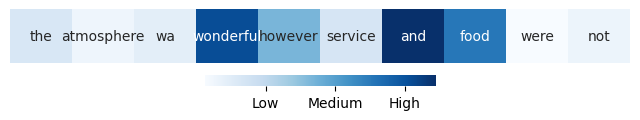

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

word_prob_df = pd.DataFrame(list(word_prob.items()), columns=['Word', 'Attention'])

fig, ax = plt.subplots(figsize=(8,1))
sns.heatmap([word_prob_df['Attention']], annot=word_prob_df[['Word']].T.values, fmt='', cmap='Blues', cbar=True, cbar_kws={'orientation':'horizontal'}, ax=ax)


cbar = ax.collections[0].colorbar
cbar.set_ticks([0.02, 0.04, 0.06])
cbar.set_ticklabels(['Low', 'Medium', 'High'])
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [69]:
first[51]

array(['The atmosphere was wonderful, however the service and food were not.',
       'food', 'negative'], dtype=object)

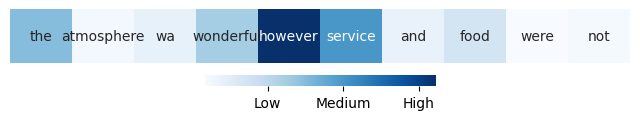

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

word_prob_df = pd.DataFrame(list(word_prob.items()), columns=['Word', 'Attention'])

fig, ax = plt.subplots(figsize=(8,1))
sns.heatmap([word_prob_df['Attention']], annot=word_prob_df[['Word']].T.values, fmt='', cmap='Blues', cbar=True, cbar_kws={'orientation':'horizontal'}, ax=ax)


cbar = ax.collections[0].colorbar
cbar.set_ticks([0.01, 0.02, 0.03])
cbar.set_ticklabels(['Low', 'Medium', 'High'])
ax.set_xticks([])
ax.set_yticks([])
plt.show()

## Hyperparameter Tuning

Used training set to training and validation set for testing

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
# Define the Attention model
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim, 6, bias=False)
        self.attn1 = nn.Linear(6*70, 70, bias=False)

    def forward(self, lstm_output):
        attention_scores = self.attn(lstm_output)
        # attention_scores = [batch size, seq_len, 6]
        attention_scores = attention_scores.reshape(attention_scores.size(0), -1)
        # attention_scores = [batch size, seq_len * 6]
        #print(attention_scores.shape)
        attention_scores1 = self.attn1(attention_scores)
        # attention_scores1 = [batch size, 50]
        return F.softmax(attention_scores1, dim=1)

# Define the BiLSTM with Attention model
class BiLSTMClassifierWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, num_classes, bidirectional=True):
        super(BiLSTMClassifierWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.dropout = dropout
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=self.dropout, batch_first=True, bidirectional=bidirectional)
        self.attention = Attention(hidden_size * 2 if bidirectional else hidden_size)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2 if bidirectional else hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes),
        )

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2 if self.bidirectional else self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2 if self.bidirectional else self.num_layers, x.size(0), self.hidden_size).to(x.device)
        lstm_output, (hidden, _) = self.lstm(x, (h0, c0))
        attention_weights = self.attention(lstm_output)
        attention_weights = attention_weights.unsqueeze(2)
        weighted = lstm_output * attention_weights
        weighted_sum = weighted.sum(dim=1)
        out = self.fc(weighted_sum)
        return out, attention_weights.squeeze(2)
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Hyperparameters
input_size = 50
hidden_sizes = (64, 128, 256, 512)
num_layers_list = (1, 2, 3)
num_classes = 3
batch_size = 256
num_epochs = 20
learning_rates = (0.1, 0.01, 0.001)
dropouts = (0.1, 0.2, 0.3, 0.4, 0.5)

# Batch Creation
max_len = 70
batches = model_1_batches(train_corpus_c_sww, batch_size, max_len)

for num_layers in num_layers_list:  # Iterate over num_layers_list
  for learning_rate in learning_rates:
    for hidden_size in hidden_sizes:
      for dropout in dropouts:
      # Initialize the model
        model_c_sww = BiLSTMClassifierWithAttention(input_size, hidden_size, num_layers, dropout, num_classes).to(device)

      # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model_c_sww.parameters(), lr=learning_rate)

        # Train the model
        for epoch in range(num_epochs):
          loss_model = 0
          for batch in batches:
            sentence_vectors, polarities = zip(*batch)
            sentence_vectors = torch.stack(sentence_vectors).to(device)
            polarities = torch.stack(polarities).to(device)

            outputs, attention_weights = model_c_sww(sentence_vectors)
            loss = criterion(outputs, polarities)
            loss_model += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        v_batches = model_1_batches(val_corpus_c_sww, batch_size, max_len)
        model_c_sww.eval()
        with torch.no_grad():
          correct = 0
          total = 0
          for batch in v_batches:
            sentence_vectors, polarities = zip(*batch)
            sentence_vectors = torch.stack(sentence_vectors).to(device)
            polarities = torch.stack(polarities).to(device)

            outputs, attention_weights = model_c_sww(sentence_vectors)
            _, predicted = torch.max(outputs.data, 1)
            total += polarities.size(0)
            correct += (predicted == polarities).sum().item()

          accuracy = 100 * correct / total
          print(f'Layers: {num_layers}, Learning rate: {learning_rate}, hidden size: {hidden_size}, Dropout: {dropout}, Accuracy: {accuracy:.4f}')
      print()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Layers: 1, Learning rate: 0.1, hidden size: 64, Dropout: 0.1, Accuracy: 43.6937


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Layers: 1, Learning rate: 0.1, hidden size: 64, Dropout: 0.2, Accuracy: 63.9640


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Layers: 1, Learning rate: 0.1, hidden size: 64, Dropout: 0.3, Accuracy: 43.6937


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Layers: 1, Learning rate: 0.1, hidden size: 64, Dropout: 0.4, Accuracy: 43.6937


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Layers: 1, Learning rate: 0.1, hidden size: 64, Dropout: 0.5, Accuracy: 43.6937

Layers: 1, Learning rate: 0.1, hidden size: 128, Dropout: 0.1, Accuracy: 43.6937
Layers: 1, Learning rate: 0.1, hidden size: 128, Dropout: 0.2, Accuracy: 58.8964
Layers: 1, Learning rate: 0.1, hidden size: 128, Dropout: 0.3, Accuracy: 43.6937
Layers: 1, Learning rate: 0.1, hidden size: 128, Dropout: 0.4, Accuracy: 43.6937
Layers: 1, Learning rate: 0.1, hidden size: 128, Dropout: 0.5, Accuracy: 43.6937

Layers: 1, Learning rate: 0.1, hidden size: 256, Dropout: 0.1, Accuracy: 43.6937
Layers: 1, Learning rate: 0.1, hidden size: 256, Dropout: 0.2, Accuracy: 43.6937
Layers: 1, Learning rate: 0.1, hidden size: 256, Dropout: 0.3, Accuracy: 43.6937
Layers: 1, Learning rate: 0.1, hidden size: 256, Dropout: 0.4, Accuracy: 43.6937
Layers: 1, Learning rate: 0.1, hidden size: 256, Dropout: 0.5, Accuracy: 43.6937

Layers: 1, Learning rate: 0.1, hidden size: 512, Dropout: 0.1, Accuracy: 43.6937
Layers: 1, Learning rate: 

## Final models

Using hyperparameters selected after tuning

### Bi-LSTM Varient-1

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the BiLSTM model
class BiLSTMClassifierModel1(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, num_classes):
        super(BiLSTMClassifierModel1, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=self.dropout, batch_first =True, bidirectional=True)
        self.fc = nn.Linear(2*hidden_size,num_classes)


    def forward(self, x):
        x,(h_n,c_n) = self.lstm(x)
        hidden_out = torch.cat((h_n[2,:,:],h_n[3,:,:]),1)
        output = self.fc(hidden_out)
        return(output)

In [242]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
input_size = 50
hidden_size = 128
num_layers = 2
num_classes = 3
batch_size = 256
num_epochs = 20
learning_rate = 0.01
dropout=0.5

# Batch Creation
max_len = 70
batches = model_1_batches(train_corpus_c_sww, batch_size, max_len)

model_1_c_sww = BiLSTMClassifierModel1(input_size, hidden_size, num_layers, dropout, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1_c_sww.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    train_loss = 0
    for batch in batches:
        sentence_vectors, polarities = zip(*batch)
        sentence_vectors = torch.stack(sentence_vectors).to(device)
        polarities = torch.stack(polarities).to(device)
        model_1_c_sww.train()
        optimizer.zero_grad()
        outputs = model_1_c_sww(sentence_vectors)
        loss = criterion(outputs, polarities)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}')

model_1_c_sww.eval()
with torch.no_grad():
  correct=0
  total=0
  for batch in batches:
    sentence_vectors, polarities = zip(*batch)
    sentence_vectors = torch.stack(sentence_vectors).to(device)
    polarities = torch.stack(polarities).to(device)

    outputs = model_1_c_sww(sentence_vectors)
    _, predicted = torch.max(outputs.data, 1)
    total += polarities.size(0)
    correct += (predicted == polarities).sum().item()
  accuracy = 100 * correct / total
  print(f'Train Accuracy: {accuracy:.2f}%')

Epoch [1/20], Loss: 28.9137
Epoch [2/20], Loss: 25.3022
Epoch [3/20], Loss: 23.6056
Epoch [4/20], Loss: 22.6999
Epoch [5/20], Loss: 21.7496
Epoch [6/20], Loss: 20.8045
Epoch [7/20], Loss: 21.1444
Epoch [8/20], Loss: 21.8652
Epoch [9/20], Loss: 19.9216
Epoch [10/20], Loss: 18.7877
Epoch [11/20], Loss: 17.0535
Epoch [12/20], Loss: 15.9630
Epoch [13/20], Loss: 15.1543
Epoch [14/20], Loss: 14.5930
Epoch [15/20], Loss: 14.4215
Epoch [16/20], Loss: 13.4263
Epoch [17/20], Loss: 12.4576
Epoch [18/20], Loss: 12.2135
Epoch [19/20], Loss: 13.5794
Epoch [20/20], Loss: 12.2847
Train Accuracy: 86.83%


In [ ]:
data = test_corpus_c_sww
sentence = data[51][0]
aspect = data[51][1]
polarity = data[51][2]

embedding_list = []
word_list = []  # Store the words in the sentence

for word in sentence:
    if str(word) in word_vectors:
        embedding_list.append(word_vectors[word])
        word_list.append(word)  # Append the word to the word_list
    else:
        embedding_list.append(np.zeros(50))
        word_list.append(word)  # Append the word to the word_list

embedding_list.append(word_vectors[aspect])
word_list.append(aspect)  # Append the aspect to the word_list

# Pad the embedding_list to max_len
padding_length = max_len - len(embedding_list)
embedding_list.extend([np.zeros(50)] * padding_length)
word_list.extend([''] * padding_length)  # Pad word_list with empty strings

batch = []
polarity_map = {'positive': 0, 'neutral': 1, 'negative': 2}
sentence_vectors = torch.tensor(embedding_list, dtype=torch.float32)
polarity = torch.tensor(polarity_map[polarity], dtype=torch.long)
batch.append((sentence_vectors, polarity))

model_1_c_sww.eval()

with torch.no_grad():
    # probabilities = []

    inputs, labels = zip(*batch)
    inputs = torch.stack(inputs).to(device)
    labels = torch.stack(labels).to(device)

    outputs = model_1_c_sww(inputs)
    probs = torch.softmax(outputs, dim=1)
    probabilities = probs.cpu().numpy()

print(probabilities)

[[1.4856434e-01 7.8681228e-04 8.5064882e-01]]


### Bi-LSTM Varient-2

In [262]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the BiLSTM model
class BiLSTMClassifierModel2(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, num_classes):
        super(BiLSTMClassifierModel2, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=self.dropout, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2 + input_size, num_classes)

    def forward(self, sentence, aspect):
        _, (hidden, _) = self.lstm(sentence)
        hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        output = torch.cat((hidden, aspect), dim=1)
        output = self.fc(output)
        return output

In [263]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
input_size = 50
hidden_size = 128
num_layers = 2
num_classes = 3
batch_size = 256
num_epochs = 20
learning_rate = 0.01
dropout=0.5

# Create batches
max_len = 70
batches = model_2_batches(train_corpus_c_sww,batch_size, max_len)

# Initialize the model
model_2_c_sww = BiLSTMClassifierModel2(input_size, hidden_size, num_layers, dropout, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_2_c_sww.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    train_loss = 0
    for batch in batches:
        sentence_vectors, aspect_vectors, polarities = zip(*batch)
        sentence_vectors = torch.stack(sentence_vectors).to(device)
        aspect_vectors = torch.stack(aspect_vectors).to(device)
        polarities = torch.stack(polarities).to(device)

        model_2_c_sww.train()
        optimizer.zero_grad()

        outputs = model_2_c_sww(sentence_vectors, aspect_vectors)
        loss = criterion(outputs, polarities)


        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}')

# Evaluate the model on the test set after training
model_2_c_sww.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for batch in batches:
        sentence_vectors, aspect_vectors, polarities = zip(*batch)
        sentence_vectors = torch.stack(sentence_vectors).to(device)
        aspect_vectors = torch.stack(aspect_vectors).to(device)
        polarities = torch.stack(polarities).to(device)

        outputs = model_2_c_sww(sentence_vectors, aspect_vectors)
        _, predicted = torch.max(outputs.data, 1)
        total += polarities.size(0)
        correct += (predicted == polarities).sum().item()

    accuracy = 100 * correct / total
    print(f'Train Accuracy: {accuracy:.2f}%')

Epoch [1/20], Loss: 26.0158
Epoch [2/20], Loss: 24.0401
Epoch [3/20], Loss: 22.9765
Epoch [4/20], Loss: 22.4440
Epoch [5/20], Loss: 21.8760
Epoch [6/20], Loss: 20.9447
Epoch [7/20], Loss: 20.4610
Epoch [8/20], Loss: 20.3974
Epoch [9/20], Loss: 19.6621
Epoch [10/20], Loss: 19.0964
Epoch [11/20], Loss: 18.2859
Epoch [12/20], Loss: 17.8752
Epoch [13/20], Loss: 18.0879
Epoch [14/20], Loss: 18.1414
Epoch [15/20], Loss: 18.2550
Epoch [16/20], Loss: 17.3158
Epoch [17/20], Loss: 16.8042
Epoch [18/20], Loss: 16.6171
Epoch [19/20], Loss: 16.2494
Epoch [20/20], Loss: 16.0966
Train Accuracy: 74.96%


### Attention Model

In [310]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Define the Attention model
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim, 6, bias=False)
        self.attn1 = nn.Linear(6*70, 70, bias=False)

    def forward(self, lstm_output):
        # lstm_output = [batch size, seq_len, hidden_dim]
        attention_scores = self.attn(lstm_output)
        # attention_scores = [batch size, seq_len, 6]
        attention_scores = attention_scores.reshape(attention_scores.size(0), -1)
        # attention_scores = [batch size, seq_len * 6]
        attention_scores1 = self.attn1(attention_scores)
        # attention_scores1 = [batch size, 50]
        return F.softmax(attention_scores1, dim=1)

# Define the BiLSTM with Attention model
class BiLSTMClassifierWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, num_classes, bidirectional=True):
        super(BiLSTMClassifierWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.dropout = dropout
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=self.dropout, batch_first=True, bidirectional=bidirectional)
        self.attention = Attention(hidden_size * 2 if bidirectional else hidden_size)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2 if bidirectional else hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes),
        )

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2 if self.bidirectional else self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2 if self.bidirectional else self.num_layers, x.size(0), self.hidden_size).to(x.device)
        lstm_output, (hidden, _) = self.lstm(x, (h0, c0))
        attention_weights = self.attention(lstm_output)
        attention_weights = attention_weights.unsqueeze(2)
        weighted = lstm_output * attention_weights
        weighted_sum = weighted.sum(dim=1)
        out = self.fc(weighted_sum)
        return out, attention_weights.squeeze(2)
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [311]:
# Hyperparameters
input_size = 50
hidden_size = 128
num_layers = 2
num_classes = 3
batch_size = 256
num_epochs = 20
learning_rate = 0.01
dropout=0.05

# Batch Creation
max_len = 70 # This is not actual max length, change input_size if you change max_len.
batches = model_1_batches(train_corpus_c_sww, batch_size, max_len)

model_c_sww = BiLSTMClassifierWithAttention(input_size, hidden_size, num_layers, dropout, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_c_sww.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    loss_model = 0
    for batch in batches:
        sentence_vectors, polarities = zip(*batch)
        sentence_vectors = torch.stack(sentence_vectors).to(device)
        polarities = torch.stack(polarities).to(device)

        outputs, attention_weights = model_c_sww(sentence_vectors)
        loss = criterion(outputs, polarities)
        loss_model +=loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss_model:.4f}')

model_c_sww.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for batch in batches:
        sentence_vectors, polarities = zip(*batch)
        sentence_vectors = torch.stack(sentence_vectors).to(device)
        polarities = torch.stack(polarities).to(device)
        outputs, attention_weights = model_c_sww(sentence_vectors)
        _, predicted = torch.max(outputs.data, 1)
        total += polarities.size(0)
        correct += (predicted == polarities).sum().item()
    accuracy = 100 * correct / total
    print(f'Train Accuracy: {accuracy:.2f}%')

Epoch [1/20], Loss: 29.7559
Epoch [2/20], Loss: 25.3015
Epoch [3/20], Loss: 24.2526
Epoch [4/20], Loss: 22.7004
Epoch [5/20], Loss: 21.5958
Epoch [6/20], Loss: 20.3563
Epoch [7/20], Loss: 18.6652
Epoch [8/20], Loss: 17.6790
Epoch [9/20], Loss: 17.3212
Epoch [10/20], Loss: 16.3397
Epoch [11/20], Loss: 14.2315
Epoch [12/20], Loss: 11.3497
Epoch [13/20], Loss: 11.0165
Epoch [14/20], Loss: 10.7412
Epoch [15/20], Loss: 9.5820
Epoch [16/20], Loss: 7.3028
Epoch [17/20], Loss: 8.1856
Epoch [18/20], Loss: 7.4596
Epoch [19/20], Loss: 5.7055
Epoch [20/20], Loss: 5.6769
Train Accuracy: 95.42%


## Ablation Study

### Bi-RNN

In [252]:
# Define the Attention model
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim, 6, bias=False)
        self.attn1 = nn.Linear(6*70, 70, bias=False)

    def forward(self, rnn_output):
        # lstm_output = [batch size, seq_len, hidden_dim]
        attention_scores = self.attn(rnn_output)
        # attention_scores = [batch size, seq_len, 6]
        attention_scores = attention_scores.reshape(attention_scores.size(0), -1)
        # attention_scores = [batch size, seq_len * 6]
        #print(attention_scores.shape)
        attention_scores1 = self.attn1(attention_scores)
        # attention_scores1 = [batch size, 50]
        return F.softmax(attention_scores1, dim=1)

# Define the BiLSTM with Attention model
class BiRNNClassifierWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, bidirectional=True):
        super(BiRNNClassifierWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        self.attention = Attention(hidden_size * 2 if bidirectional else hidden_size)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2 if bidirectional else hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes),
        )

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2 if self.bidirectional else self.num_layers, x.size(0), self.hidden_size).to(x.device)

        rnn_output, h_n = self.rnn(x, h0)
        attention_weights = self.attention(rnn_output)
        attention_weights = attention_weights.unsqueeze(2)
        weighted = rnn_output * attention_weights
        weighted_sum = weighted.sum(dim=1)
        out = self.fc(weighted_sum)
        return out, attention_weights.squeeze(2)
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
input_size = 50
hidden_size = 256
num_layers = 2
num_classes = 3
batch_size = 256
num_epochs = 20
learning_rate = 0.001

# Batch Creation
max_len = 70 # This is not actual max length, change input_size if you change max_len.
batches = model_1_batches(train_corpus_c_sww, batch_size, max_len)

model_rnn_sww = BiRNNClassifierWithAttention(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_rnn_sww.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    loss_model = 0
    for batch in batches:
        sentence_vectors, polarities = zip(*batch)
        sentence_vectors = torch.stack(sentence_vectors).to(device)
        polarities = torch.stack(polarities).to(device)

        outputs, attention_weights = model_rnn_sww(sentence_vectors)
        loss = criterion(outputs, polarities)
        loss_model +=loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss_model:.4f}')

model_rnn_sww.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for batch in batches:
        sentence_vectors, polarities = zip(*batch)
        sentence_vectors = torch.stack(sentence_vectors).to(device)
        polarities = torch.stack(polarities).to(device)
        outputs, attention_weights = model_rnn_sww(sentence_vectors)
        _, predicted = torch.max(outputs.data, 1)
        total += polarities.size(0)
        correct += (predicted == polarities).sum().item()
    accuracy = 100 * correct / total
    print(f'Train Accuracy: {accuracy:.2f}%')

Epoch [1/20], Loss: 29.2215
Epoch [2/20], Loss: 26.3207
Epoch [3/20], Loss: 24.8450
Epoch [4/20], Loss: 24.3356
Epoch [5/20], Loss: 24.1349
Epoch [6/20], Loss: 23.5552
Epoch [7/20], Loss: 22.8603
Epoch [8/20], Loss: 22.5607
Epoch [9/20], Loss: 21.8998
Epoch [10/20], Loss: 21.7747
Epoch [11/20], Loss: 21.3539
Epoch [12/20], Loss: 20.7929
Epoch [13/20], Loss: 20.2869
Epoch [14/20], Loss: 19.8432
Epoch [15/20], Loss: 19.3274
Epoch [16/20], Loss: 19.0057
Epoch [17/20], Loss: 18.7914
Epoch [18/20], Loss: 18.3500
Epoch [19/20], Loss: 17.7715
Epoch [20/20], Loss: 17.2484
Train Accuracy: 72.91%


In [254]:
model_rnn_sww.eval()
with torch.no_grad():
    correct = 0
    total = 0
    batches = model_1_batches(test_corpus_c_sww, batch_size, max_len)
    for batch in batches:
        sentence_vectors, polarities = zip(*batch)
        sentence_vectors = torch.stack(sentence_vectors).to(device)
        polarities = torch.stack(polarities).to(device)
        outputs, attention_weights = model_rnn_sww(sentence_vectors)
        _, predicted = torch.max(outputs.data, 1)
        total += polarities.size(0)
        correct += (predicted == polarities).sum().item()
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 59.49%


### Bi-GRU

In [255]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim, 6, bias=False)
        self.attn1 = nn.Linear(6*70, 70, bias=False)

    def forward(self, output):
        # lstm_output = [batch size, seq_len, hidden_dim]
        attention_scores = self.attn(output)
        # attention_scores = [batch size, seq_len, 6]
        attention_scores = attention_scores.reshape(attention_scores.size(0), -1)
        # attention_scores = [batch size, seq_len * 6]
        #print(attention_scores.shape)
        attention_scores1 = self.attn1(attention_scores)
        # attention_scores1 = [batch size, 50]
        return F.softmax(attention_scores1, dim=1)

# Define the BiLSTM with Attention model
class BiGRUClassifierWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, bidirectional=True):
        super(BiGRUClassifierWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        self.attention = Attention(hidden_size * 2 if bidirectional else hidden_size)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2 if bidirectional else hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes),
        )

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2 if self.bidirectional else self.num_layers, x.size(0), self.hidden_size).to(x.device)

        gru_output, h_n = self.gru(x, h0)
        attention_weights = self.attention(gru_output)
        attention_weights = attention_weights.unsqueeze(2)
        weighted = gru_output * attention_weights
        weighted_sum = weighted.sum(dim=1)
        out = self.fc(weighted_sum)
        return out, attention_weights.squeeze(2)
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
input_size = 50
hidden_size = 256
num_layers = 2
num_classes = 3
batch_size = 256
num_epochs = 20
learning_rate = 0.001

# Batch Creation
max_len = 70
batches = model_1_batches(train_corpus_c_sww, batch_size, max_len)

model_gru_sww = BiGRUClassifierWithAttention(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_gru_sww.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    loss_model = 0
    for batch in batches:
        sentence_vectors, polarities = zip(*batch)
        sentence_vectors = torch.stack(sentence_vectors).to(device)
        polarities = torch.stack(polarities).to(device)

        outputs, attention_weights = model_gru_sww(sentence_vectors)
        loss = criterion(outputs, polarities)
        loss_model +=loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss_model:.4f}')

model_gru_sww.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for batch in batches:
        sentence_vectors, polarities = zip(*batch)
        sentence_vectors = torch.stack(sentence_vectors).to(device)
        polarities = torch.stack(polarities).to(device)
        outputs, attention_weights = model_gru_sww(sentence_vectors)
        _, predicted = torch.max(outputs.data, 1)
        total += polarities.size(0)
        correct += (predicted == polarities).sum().item()
    accuracy = 100 * correct / total
    print(f'Train Accuracy: {accuracy:.2f}%')

Epoch [1/20], Loss: 28.7539
Epoch [2/20], Loss: 25.0442
Epoch [3/20], Loss: 23.6502
Epoch [4/20], Loss: 22.9575
Epoch [5/20], Loss: 22.5102
Epoch [6/20], Loss: 21.9780
Epoch [7/20], Loss: 21.4944
Epoch [8/20], Loss: 21.0277
Epoch [9/20], Loss: 20.4423
Epoch [10/20], Loss: 19.6973
Epoch [11/20], Loss: 18.8277
Epoch [12/20], Loss: 17.9179
Epoch [13/20], Loss: 17.0076
Epoch [14/20], Loss: 16.0141
Epoch [15/20], Loss: 16.0173
Epoch [16/20], Loss: 16.3605
Epoch [17/20], Loss: 14.6974
Epoch [18/20], Loss: 13.3278
Epoch [19/20], Loss: 11.9828
Epoch [20/20], Loss: 10.9028
Train Accuracy: 86.90%


In [256]:
model_gru_sww.eval()
with torch.no_grad():
    correct = 0
    total = 0
    batches = model_1_batches(test_corpus_c_sww, batch_size, max_len)
    for batch in batches:
        sentence_vectors, polarities = zip(*batch)
        sentence_vectors = torch.stack(sentence_vectors).to(device)
        polarities = torch.stack(polarities).to(device)
        outputs, attention_weights = model_gru_sww(sentence_vectors)
        _, predicted = torch.max(outputs.data, 1)
        total += polarities.size(0)
        correct += (predicted == polarities).sum().item()
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 62.93%


### Bi-RNN with attention by adding aspect with each word

In [330]:
def model_3_batches(data, batch_size, max_len):
    batches = []
    polarity_map = {'positive': 0, 'neutral': 1, 'negative': 2}

    for i in range(0, len(data), batch_size):
        batch = []

        for j in range(i, min(i + batch_size, len(data))):
            sentence = data[j][0]
            aspect = data[j][1]
            polarity = data[j][2]
            embedding_list = []
            for word in sentence: # Check if word exist in pre-trained word embedding else appending zero vector
                if str(word) in word_vectors:
                    embedding_list.append(word_vectors[word])
                else:
                    embedding_list.append(np.zeros(50))

            embedding_list.append(word_vectors[aspect])

            for _ in range(max_len - len(embedding_list)):
                embedding_list.append(np.zeros(50))

            sentence_vectors = torch.tensor(embedding_list, dtype=torch.float32)
            aspect_vectors = torch.tensor(word_vectors[aspect], dtype=torch.float32)
            polarity = torch.tensor(polarity_map[polarity], dtype=torch.long)

            batch.append((sentence_vectors, aspect_vectors, polarity))

        batches.append(batch)

    return batches

In [332]:
# Define the Attention model
class Attention(nn.Module):
    def __init__(self, hidden_dim, input_size):
        super().__init__()
        self.attn = nn.Linear(hidden_dim + input_size, 6, bias=False)
        self.attn1 = nn.Linear(6 * max_len, max_len, bias=False)  # Use max_len instead of hardcoded value

    def forward(self, rnn_output, aspect_vectors):
    # lstm_output = [batch size, seq_len, hidden_dim]
      aspect_vectors = aspect_vectors.unsqueeze(1).expand(-1, rnn_output.size(1), -1)  # Add extra dimension and expand

      attention_scores = self.attn(torch.cat((rnn_output, aspect_vectors), dim=2))
    # attention_scores = [batch size, seq_len, 6]
      attention_scores = attention_scores.reshape(attention_scores.size(0), -1)
    # attention_scores = [batch size, seq_len * 6]
      attention_scores1 = self.attn1(attention_scores)
    # attention_scores1 = [batch size, max_len]
      return F.softmax(attention_scores1, dim=1)


class BiRNNClassifierWithAttentionAspect(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, bidirectional=True):
        super(BiRNNClassifierWithAttentionAspect, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        self.attention = Attention(hidden_size * 2 if bidirectional else hidden_size, input_size)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2 if bidirectional else hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes),
        )

    def forward(self, x, aspect_vectors):
        h0 = torch.zeros(self.num_layers * 2 if self.bidirectional else self.num_layers, x.size(0), self.hidden_size).to(x.device)
        rnn_output, h_n = self.rnn(x, h0)
        attention_weights = self.attention(rnn_output, aspect_vectors)
        attention_weights = attention_weights.unsqueeze(2)
        weighted = rnn_output * attention_weights
        weighted_sum = weighted.sum(dim=1)
        out = self.fc(weighted_sum)
        return out, attention_weights.squeeze(2)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
input_size = 50
hidden_size = 128
num_layers = 2
num_classes = 3
batch_size = 256
num_epochs = 20
learning_rate = 0.001

# Batch Creation
max_len = 70
batches = model_3_batches(train_corpus_c_sww, batch_size, max_len)

model_rnn_sww = BiRNNClassifierWithAttentionAspect(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_rnn_sww.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    loss_model = 0
    for batch in batches:
        sentence_vectors, aspect_vectors, polarities = zip(*batch)
        sentence_vectors = torch.stack(sentence_vectors).to(device)
        aspect_vectors = torch.stack(aspect_vectors).to(device)
        polarities = torch.stack(polarities).to(device)

        outputs, attention_weights = model_rnn_sww(sentence_vectors, aspect_vectors)
        loss = criterion(outputs, polarities)
        loss_model += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss_model:.4f}')

model_rnn_sww.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for batch in batches:
        sentence_vectors, aspect_vectors, polarities = zip(*batch)  # Add aspect_vectors
        sentence_vectors = torch.stack(sentence_vectors).to(device)
        aspect_vectors = torch.stack(aspect_vectors).to(device)  # Add aspect_vectors
        polarities = torch.stack(polarities).to(device)
        outputs, attention_weights = model_rnn_sww(sentence_vectors, aspect_vectors)  # Pass aspect_vectors
        _, predicted = torch.max(outputs.data, 1)
        total += polarities.size(0)
        correct += (predicted == polarities).sum().item()
    accuracy = 100 * correct / total
    print(f'Train Accuracy: {accuracy:.2f}%')

Epoch [1/20], Loss: 27.6524
Epoch [2/20], Loss: 24.8920
Epoch [3/20], Loss: 24.1960
Epoch [4/20], Loss: 23.8749
Epoch [5/20], Loss: 23.3572
Epoch [6/20], Loss: 23.0718
Epoch [7/20], Loss: 22.7153
Epoch [8/20], Loss: 22.4554
Epoch [9/20], Loss: 22.0809
Epoch [10/20], Loss: 21.5781
Epoch [11/20], Loss: 21.2340
Epoch [12/20], Loss: 20.7719
Epoch [13/20], Loss: 20.3385
Epoch [14/20], Loss: 20.0289
Epoch [15/20], Loss: 19.7159
Epoch [16/20], Loss: 18.9631
Epoch [17/20], Loss: 18.6324
Epoch [18/20], Loss: 18.3697
Epoch [19/20], Loss: 17.7808
Epoch [20/20], Loss: 17.4213
Train Accuracy: 73.95%


In [333]:
model_rnn_sww.eval()
with torch.no_grad():
    correct = 0
    total = 0
    batches = model_3_batches(test_corpus_c_sww, batch_size, max_len)
    for batch in batches:
        sentence_vectors, aspect_vectors, polarities = zip(*batch)  # Add aspect_vectors
        sentence_vectors = torch.stack(sentence_vectors).to(device)
        aspect_vectors = torch.stack(aspect_vectors).to(device)  # Add aspect_vectors
        polarities = torch.stack(polarities).to(device)
        outputs, attention_weights = model_rnn_sww(sentence_vectors, aspect_vectors)  # Pass aspect_vectors
        _, predicted = torch.max(outputs.data, 1)
        total += polarities.size(0)
        correct += (predicted == polarities).sum().item()
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 57.38%


### Bi-GRU with attention by adding aspect with each word

In [342]:
class Attention(nn.Module):
    def __init__(self, hidden_dim, input_size):
        super().__init__()
        self.attn = nn.Linear(hidden_dim + input_size, 6, bias=False)
        self.attn1 = nn.Linear(6 * max_len, max_len, bias=False)

    def forward(self, output, aspect_vectors):
        # lstm_output = [batch size, seq_len, hidden_dim]
        aspect_vectors = aspect_vectors.unsqueeze(1).expand(-1, output.size(1), -1)
        attention_scores = self.attn(torch.cat((output, aspect_vectors), dim=2))
        # attention_scores = [batch size, seq_len, 6]
        attention_scores = attention_scores.reshape(attention_scores.size(0), -1)
        # attention_scores = [batch size, seq_len * 6]
        #print(attention_scores.shape)
        attention_scores1 = self.attn1(attention_scores)
        # attention_scores1 = [batch size, 50]
        return F.softmax(attention_scores1, dim=1)

# Define the BiLSTM with Attention model
class BiGRUClassifierWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, bidirectional=True):
        super(BiGRUClassifierWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        self.attention = Attention(hidden_size * 2 if bidirectional else hidden_size, input_size)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2 if bidirectional else hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes),
        )

    def forward(self, x, aspect_vectors):
        h0 = torch.zeros(self.num_layers * 2 if self.bidirectional else self.num_layers, x.size(0), self.hidden_size).to(x.device)

        gru_output, h_n = self.gru(x, h0)
        attention_weights = self.attention(gru_output, aspect_vectors)
        attention_weights = attention_weights.unsqueeze(2)
        weighted = gru_output * attention_weights
        weighted_sum = weighted.sum(dim=1)
        out = self.fc(weighted_sum)
        return out, attention_weights.squeeze(2)
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
input_size = 50
hidden_size = 256
num_layers = 2
num_classes = 3
batch_size = 256
num_epochs = 20
learning_rate = 0.001

# Batch Creation
max_len = 70
batches = model_3_batches(train_corpus_c_sww, batch_size, max_len)

model_gru_sww = BiGRUClassifierWithAttention(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_gru_sww.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    loss_model = 0
    for batch in batches:
        sentence_vectors, aspect_vectors, polarities = zip(*batch)
        sentence_vectors = torch.stack(sentence_vectors).to(device)
        aspect_vectors = torch.stack(aspect_vectors).to(device)
        polarities = torch.stack(polarities).to(device)

        outputs, attention_weights = model_gru_sww(sentence_vectors, aspect_vectors)
        loss = criterion(outputs, polarities)
        loss_model +=loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss_model:.4f}')

model_gru_sww.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for batch in batches:
        sentence_vectors, aspect_vectors, polarities = zip(*batch)
        sentence_vectors = torch.stack(sentence_vectors).to(device)
        aspect_vectors = torch.stack(aspect_vectors).to(device)
        polarities = torch.stack(polarities).to(device)
        outputs, attention_weights = model_gru_sww(sentence_vectors, aspect_vectors)
        _, predicted = torch.max(outputs.data, 1)
        total += polarities.size(0)
        correct += (predicted == polarities).sum().item()
    accuracy = 100 * correct / total
    print(f'Train Accuracy: {accuracy:.2f}%')

Epoch [1/20], Loss: 28.3723
Epoch [2/20], Loss: 24.5645
Epoch [3/20], Loss: 23.6989
Epoch [4/20], Loss: 23.1126
Epoch [5/20], Loss: 22.6465
Epoch [6/20], Loss: 22.1926
Epoch [7/20], Loss: 21.6821
Epoch [8/20], Loss: 21.1328
Epoch [9/20], Loss: 20.4914
Epoch [10/20], Loss: 19.8538
Epoch [11/20], Loss: 19.1883
Epoch [12/20], Loss: 18.1199
Epoch [13/20], Loss: 17.8897
Epoch [14/20], Loss: 17.3439
Epoch [15/20], Loss: 16.0932
Epoch [16/20], Loss: 14.0347
Epoch [17/20], Loss: 12.7591
Epoch [18/20], Loss: 12.4764
Epoch [19/20], Loss: 12.3456
Epoch [20/20], Loss: 11.9433
Train Accuracy: 80.94%


In [343]:
model_gru_sww.eval()
with torch.no_grad():
    correct = 0
    total = 0
    batches = model_3_batches(test_corpus_c_sww, batch_size, max_len)
    for batch in batches:
        sentence_vectors, aspect_vectors, polarities = zip(*batch)
        sentence_vectors = torch.stack(sentence_vectors).to(device)
        aspect_vectors = torch.stack(aspect_vectors).to(device)
        polarities = torch.stack(polarities).to(device)
        outputs, attention_weights = model_gru_sww(sentence_vectors, aspect_vectors)
        _, predicted = torch.max(outputs.data, 1)
        total += polarities.size(0)
        correct += (predicted == polarities).sum().item()
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 64.59%


# 3.Testing and Evaluation

## Testing on Bi-LSTM varient-1

In [327]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
model_1_c_sww.eval()
with torch.no_grad():
  pred_polarity=[]
  act_polarity=[]
  correct=0
  total=0
  crr=0
  batches = model_1_batches(test_corpus_c_sww, batch_size, max_len)
  for batch in batches:
    sentence_vectors, polarities = zip(*batch)
    sentence_vectors = torch.stack(sentence_vectors).to(device)
    polarities = torch.stack(polarities).to(device)

    outputs = model_1_c_sww(sentence_vectors)
    _, predicted = torch.max(outputs.data, 1)
    pred_polarity.extend(predicted)
    act_polarity.extend(polarities)
    total += polarities.size(0)
    correct += (predicted == polarities).sum().item()
  accuracy = 100 * correct / total

  act_polarity = [int(i) for i in act_polarity]
  pred_polarity = [int(i) for i in pred_polarity]

  p_score = precision_score(act_polarity, pred_polarity, average="weighted")
  r_score = recall_score(act_polarity, pred_polarity, average="weighted")
  f1_score = f1_score(act_polarity, pred_polarity, average="weighted")

  print(f'precision: {100*(p_score):.2f}%')
  print(f'recall: {100*(r_score):.2f}%')
  print(f'f1-score: {100*(f1_score):.2f}%')
  print(f'Test Accuracy: {accuracy:.2f}%')

precision: 61.91%
recall: 63.37%
f1-score: 61.75%
Test Accuracy: 63.37%


## Testing on Bi-LSTM varient-2

In [323]:
model_2_c_sww.eval()
with torch.no_grad():
    correct = 0
    total = 0
    pred_polarity=[]
    act_polarity=[]
    batches = model_2_batches(test_corpus_c_sww,batch_size, max_len)
    for batch in batches:
        sentence_vectors, aspect_vectors, polarities = zip(*batch)
        sentence_vectors = torch.stack(sentence_vectors).to(device)
        aspect_vectors = torch.stack(aspect_vectors).to(device)
        polarities = torch.stack(polarities).to(device)

        outputs = model_2_c_sww(sentence_vectors, aspect_vectors)
        _, predicted = torch.max(outputs.data, 1)
        pred_polarity.extend(predicted)
        act_polarity.extend(polarities)
        total += polarities.size(0)
        correct += (predicted == polarities).sum().item()

    act_polarity = [int(i) for i in act_polarity]
    pred_polarity = [int(i) for i in pred_polarity]
    accuracy = 100 * correct / total

    p_score=precision_score(act_polarity, pred_polarity, average="weighted")
    r_score=recall_score(act_polarity, pred_polarity, average="weighted")
    f1_score=f1_score(act_polarity, pred_polarity, average="weighted")

    print(f'precision: {100*(p_score):.2f}%')
    print(f'recall: {100*(r_score):.2f}%')
    print(f'f1-score: {100*(f1_score):.2f}%')
    print(f'Test Accuracy: {accuracy:.2f}%')


precision: 62.74%
recall: 63.60%
f1-score: 62.58%
Test Accuracy: 63.60%


## Testing on Attention Model

In [326]:
model_c_sww.eval()
with torch.no_grad():
    correct = 0
    total = 0
    pred_polarity=[]
    act_polarity=[]
    batches = model_1_batches(test_corpus_c_sww,batch_size, max_len)
    for batch in batches:
        sentence_vectors, polarities = zip(*batch)
        sentence_vectors = torch.stack(sentence_vectors).to(device)
        polarities = torch.stack(polarities).to(device)
        outputs, attention_weights = model_c_sww(sentence_vectors)
        _, predicted = torch.max(outputs.data, 1)
        pred_polarity.extend(predicted)
        act_polarity.extend(polarities)
        total += polarities.size(0)
        correct += (predicted == polarities).sum().item()
    accuracy = 100 * correct / total

    act_polarity = [int(i) for i in act_polarity]
    pred_polarity = [int(i) for i in pred_polarity]

    p_score=precision_score(act_polarity, pred_polarity, average="weighted")
    r_score=recall_score(act_polarity, pred_polarity, average="weighted")
    f1_score=f1_score(act_polarity, pred_polarity, average="weighted")

    print(f'precision: {100*(p_score):.2f}%')
    print(f'recall: {100*(r_score):.2f}%')
    print(f'f1-score: {100*(f1_score):.2f}%')
    print(f'Test Accuracy: {accuracy:.2f}%')

precision: 64.33%
recall: 64.04%
f1-score: 64.14%
Test Accuracy: 64.04%


Epoch [1/20], Loss: 28.2862
Epoch [2/20], Loss: 24.5082
Epoch [3/20], Loss: 23.7795
Epoch [4/20], Loss: 23.1023
Epoch [5/20], Loss: 22.5917
Epoch [6/20], Loss: 22.2497
Epoch [7/20], Loss: 21.7570
Epoch [8/20], Loss: 21.0685
Epoch [9/20], Loss: 20.4015
Epoch [10/20], Loss: 19.8215
Epoch [11/20], Loss: 18.9575
Epoch [12/20], Loss: 18.0702
Epoch [13/20], Loss: 17.6005
Epoch [14/20], Loss: 17.2234
Epoch [15/20], Loss: 16.0303
Epoch [16/20], Loss: 14.5252
Epoch [17/20], Loss: 14.0334
Epoch [18/20], Loss: 12.5849
Epoch [19/20], Loss: 11.5607
Epoch [20/20], Loss: 11.7134
Train Accuracy: 85.18%


Test Accuracy: 64.82%
